In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats
import scipy.linalg
import scipy.signal

from rfest import get_stimulus_design_matrix
from rfest import ARD, ASD, ALD, splineLG

The following script to simulate correlated noise data is ported from matlab code by [leaduncker](https://github.com/leaduncker/SimpleEvidenceOpt).

# Make 2D Receptive Field

In [2]:
dt = 1/60 # time bin size
nt = 30
nx = 40
tt = np.arange(-nt*dt, 0, dt)

kt1 = scipy.stats.gamma.pdf(-tt, 4, scale=.025)
kt2 = scipy.stats.gamma.pdf(-tt, 6, scale=.03)
kt1 /= np.linalg.norm(kt1)
kt2 /= -np.linalg.norm(kt2)

kt = np.vstack([kt1, kt2]).T

xx = np.linspace(-2, 2, nx)

kx1 = np.cos(2*np.pi*xx/2 + np.pi/5) * np.exp(-1/(2*0.35**2) * xx**2)
kx2 = np.sin(2*np.pi*xx/2 + np.pi/5) * np.exp(-1/(2*0.35**2) * xx**2)

kx1 /= np.linalg.norm(kx1)
kx2 /= np.linalg.norm(kx2)

kx = np.vstack([kx1, kx2])

k = kt @ kx

Text(0.5, 1.0, 'True Receptive Field')

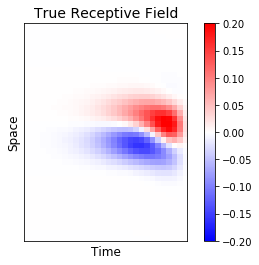

In [3]:
plt.imshow(k.T, cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel('Time', fontsize=12)
plt.ylabel('Space', fontsize=12)
plt.title('True Receptive Field', fontsize=14)

# Simulate Correlated Noise and Response

In [4]:
N = 5000 # sample size
signse = 1 # noise stdev
Sigma = scipy.linalg.toeplitz(np.exp(-(np.arange(0, nx)) / (nx/6)))

mu = np.zeros(nx)
Stim = np.random.multivariate_normal(mu, Sigma, N)
X = get_stimulus_design_matrix(Stim, nt)
y = X @ k.flatten() + signse * np.random.randn(N)

dims = [nt, nx] # Receptive fields dims

# Run ASD, ALD, splineLG

In [5]:
asd = ASD(X, y, dims, compute_mle=False)
asd.fit(initial_params=np.array([1. , 1., 7., 7.,]), num_iters=10)

Iter	σ	ρ	δt	δs	cost


/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:115: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


   0	1.010	0.990	6.990	7.010	17628.276
   1	1.020	0.983	6.984	7.020	17389.654
   2	1.030	0.978	6.980	7.029	17183.517
   3	1.040	0.974	6.977	7.038	16937.770
   4	1.050	0.969	6.976	7.045	16749.806
   5	1.060	0.967	6.977	7.053	16527.091
   6	1.070	0.964	6.978	7.060	16340.012
   7	1.079	0.962	6.979	7.067	16162.367
   8	1.089	0.959	6.980	7.075	16001.094
   9	1.099	0.956	6.982	7.083	15782.792
Stop: reached maxiter = 10.


In [6]:
ald = ALD(X, y, dims, compute_mle=False)

sigma0 = [1.]
rho0 = [1.]
params_t0 = [6., 20., 1., 1.] # taus, nus, tauf, nuf
params_y0 = [6., 20., 1., 1.]
init_params = sigma0 + rho0 + params_t0 + params_y0
ald.fit(initial_params=init_params, num_iters=10)

Iter	σ	ρ	τs_t	τf_t	τs_y	τf_y	cost
   0	1.010	0.990	5.990	1.010	5.990	1.010	13714.494
   1	1.020	0.980	5.981	1.020	5.980	1.020	13441.986
   2	1.030	0.984	5.973	1.027	5.982	1.027	13194.656
   3	1.040	0.988	5.966	1.034	5.980	1.036	12955.735
   4	1.050	0.990	5.959	1.043	5.979	1.044	12723.122
   5	1.060	0.994	5.952	1.051	5.977	1.050	12507.042
   6	1.070	0.996	5.947	1.060	5.973	1.057	12294.473
   7	1.079	0.998	5.943	1.069	5.970	1.061	12093.641
   8	1.089	1.001	5.939	1.078	5.969	1.065	11897.894
   9	1.099	1.004	5.936	1.087	5.968	1.069	11707.722
Stop: reached maxiter = 10.


In [7]:
spl = splineLG(X, y, dims=dims, df_splines=14, compute_mle=True)
spl.fit(num_iters=500, verbal=100, alpha=1, lambd=0.1)

Iter	Cost	
0	4.755	
100	1.251	
200	1.251	
300	1.254	
400	1.254	
Stop: reached 500 steps, final cost=1.2552436796254476.


# Plot Results

Text(0, 0.5, 'Space')

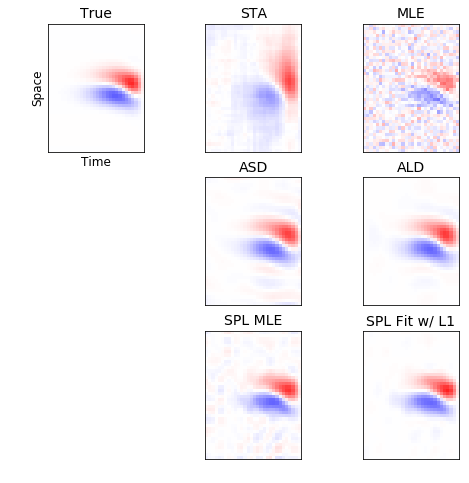

In [8]:
fig, ax = plt.subplots(3,3, figsize=(8, 8))
ax = ax.flatten()
labels = ['True', 'STA', 'MLE', '', 'ASD', 'ALD', '', 'SPL MLE', 'SPL Fit w/ L1']
for ii, w in enumerate([k, spl.w_sta, spl.w_mle, 0, asd.w_opt, ald.w_opt , 0, spl.w_spl, spl.w_opt]):
    
    if np.ndim(w) == 0:
        ax[ii].axis('off')
        continue
    
    w = w.reshape(dims) 
    w /= np.linalg.norm(w)
    ax[ii].imshow(w.T, cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
    ax[ii].set_title(labels[ii], fontsize=14)
    ax[ii].set_xticks([])
    ax[ii].set_yticks([])
ax[0].set_xlabel('Time', fontsize=12)
ax[0].set_ylabel('Space', fontsize=12)